# **IDENTIFICACIÓN Y CARACTERIZACIÓN DE MATERIALES 2D USANDO TÉCNICAS DE PROCESAMIENTO DE IMAGENES E INTELIGENCIA ARTIFICIAL**

# **Análisis exploratorio de datos**                  

# Indice
1. Objetivo
2. Librerías
3. Importación de datos
4. Lectura de imagenes
5. Descripción de la base de datos         
  5.1. Tamaño de la base de datos y dimensiones
6. Visualización de datos   
   6.1. Distribución de clases a nivel de etiquetas   
   6.2. Distribución de clases a nivel de pixeles   
   6.3. Mapa de calor
7. Análisis de caracteristicas   
  7.1. Histograma de intensidad en escala de grises    
  7.2. Histograma del canal RGB   
  7.3. Diagrama de cajas RGB por clases   
  7.4. Ejemplo de imagen filtrada por canales   
  7.5. Modelo HSV   
  7.6. Diagrama de cajas HSV por clases   

#1. Objetivo

Los materiales bidimensionales (2D) son una clase de sólidos cristalinos que presentan una amplia gama de propiedades electrónicas de interés para aplicaciones en electrónica, almacenamiento de energía, catálisis e incluso medicina. Sin embargo, la obtención de estos no es una labor sencilla, pues requiere de un experto humano que seleccione de manera manual y usando un microscopio, las regiones de interés correspondientes a los materiales de interés. Debido a lo anterior, han surgido diversos intentos de automatizar el proceso de segmentación de imágenes para la identificación automática de los materiales 2D para reducir el tiempo requerido en la obtención de estos. El presente trabajo propone la construcción de un modelo basado en técnicas de procesamiento de imágenes y/o inteligencia artificial para la automatización del proceso de identificación de regiones de interés sobre imágenes obtenidas en el Laboratorio de Fotónica de la Universidad de Mackenzie, en Brasil.
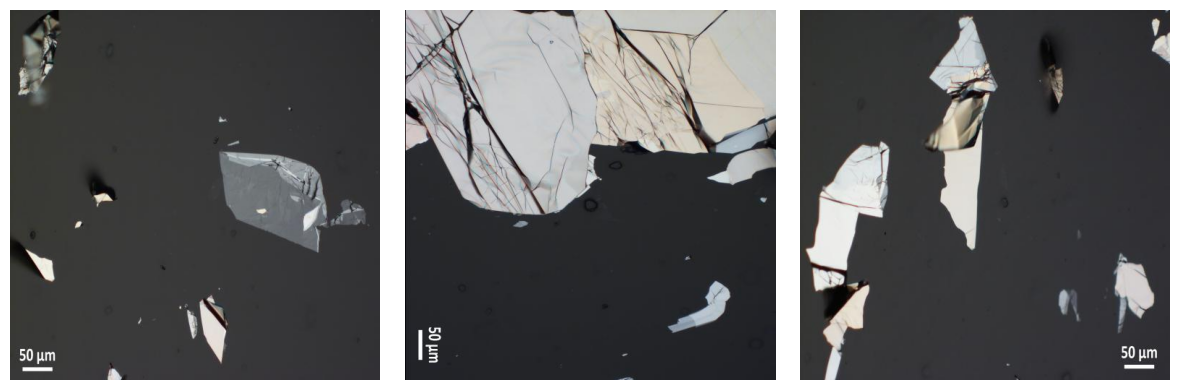


#2. Librerías
Se importan solo las librerías necesarias para hacer la lectura e interpretación de las imagenes

In [ ]:
!pip install roboflow

In [ ]:
from roboflow import Roboflow
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from skimage import measure
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

#3.  Importación de datos
Se importan las imagenes directamente desde Roboflow para optimizar los tiempos de importación de datos y hacer uso del repositorio global para cualquier usuario que desee reproducir este trabajo

In [ ]:
rf = Roboflow(api_key="YJeW9pVCy9nQ7BwHkRIO")
project = rf.workspace("2d-materials-segmentation").project("2d-materials-segmentation")
version = project.version(4)
dataset_mask = version.download("png-mask-semantic")
dataset = version.download("coco-segmentation")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to 2D-Materials-segmentation-4 in png-mask-semantic:: 100%|██████████| 88/88 [00:00<00:00, 1073.85it/s]


Exporting format coco-segmentation in progress : 50.0%
Version export complete for coco-segmentation format


#4. Lectura de imagenes
Teniendo las carpetas con las imagenes cargadas se procede a hacer la lectura de las imagenes usando las rutas de ubicación

In [ ]:
def get_img_dir_arr_sorted(base_path):
  """
  Código para obtener las rutas de las imagenes de manera ordenada a formato Array
  base_path: ruta base de las imagenes
  return: array con las rutas de las imagenes ordenadas
  """
  img_dir_list = os.listdir(base_path)
  if '_classes.csv' in img_dir_list:
    img_dir_list.remove('_classes.csv')

  img_dir_list.sort()
  img_dir_list_sorted_mapped = list(map(lambda x: os.path.join(base_path, x),
                             img_dir_list))

  # Observe que la longitud de la lista debe ser par
  img_dir_arr = np.array(img_dir_list_sorted_mapped).reshape(-1,2)
  return img_dir_arr

In [ ]:
def get_imgs_from_dir_arr(dir_arr):
    """
    Código para obtener las imagenes de manera ordenada
    .extend: agrega elementos a una lista existente
    dir_arr: array con las rutas de las imagenes ordenadas
    img_list: lista de imagenes
    mask_list: lista de máscaras
    return: dos arrays con las imagenes y máscaras ordenadas
    """
    img_list = []  # Lista de imágenes
    mask_list = []  # Lista de máscaras

    # Carga de imágenes y máscaras con aumentos
    for item in dir_arr:
        img_path = os.path.join(item[0])
        mask_path = os.path.join(item[1])

        img = cv2.imread(img_path)  # Escala de grises
        mask = cv2.imread(mask_path)  # Escala de grises

        img_list.append(img)
        mask_list.append(mask)

    return np.array(img_list), np.array(mask_list)

In [ ]:
#Se obtienen las rutas de las imagenes de entrenamiento, validación y test
train_paths = get_img_dir_arr_sorted('/content/2D-Materials-segmentation-1/train')
test_paths = get_img_dir_arr_sorted('/content/2D-Materials-segmentation-1/test')
valid_paths = get_img_dir_arr_sorted('/content/2D-Materials-segmentation-1/valid')

#Se obtienen las imagenes y máscaras de entrenamiento, validación y test
train_images, train_masks = get_imgs_from_dir_arr(train_paths)
test_images, test_masks = get_imgs_from_dir_arr(test_paths)
valid_images, valid_masks = get_imgs_from_dir_arr(valid_paths)

In [ ]:
len(valid_images)

13

#5. Descripción de la base de datos
La base de datos utilizada consta de 63 imágenes obtenidas mediante un microscopio Olympus BX51M en el Laboratorio de Fotónica de la Universidad de Mackenzie, en Brasil. Las imágenes contienen muestras de Bulk y few layer, las cuales han sido segmentadas con el fin de realizar su clasificación a través de segmentación semántica. Además de estas dos clases de interés, se incluye una clase adicional de fondo (background)

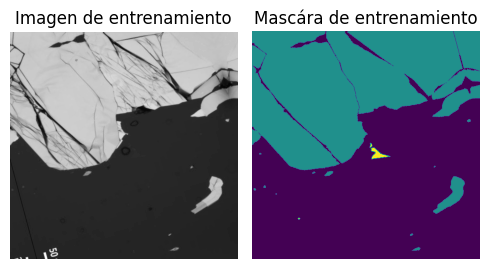

##5.1. Tamaño de la base de datos e imágenes

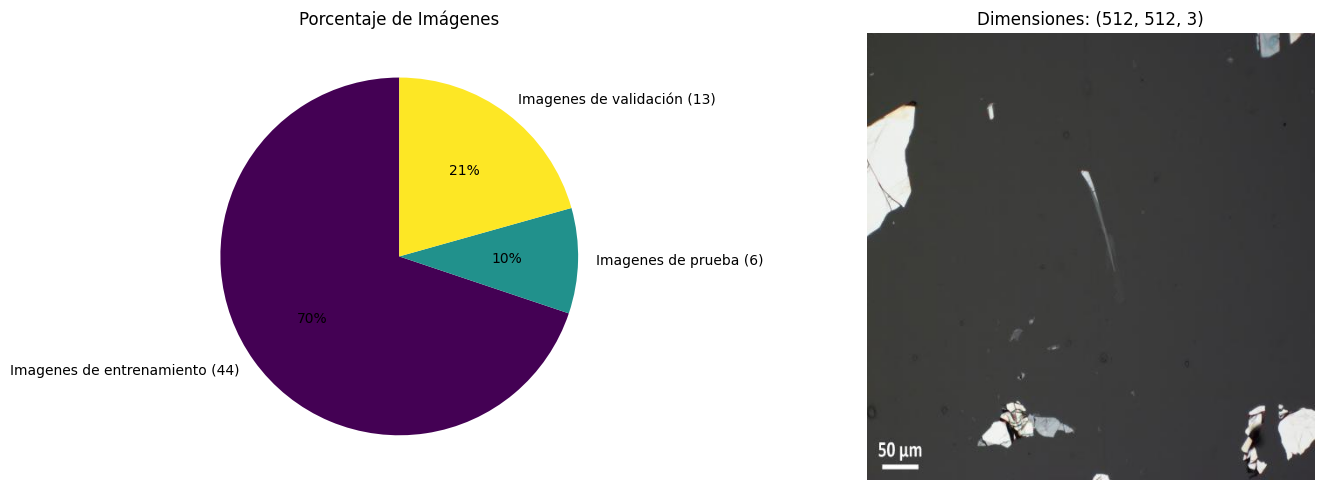

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

if len(train_images) > 0:
    img_path = "/content/2D-Materials-segmentation-1/test/16_Grafeno-em-PDMS_Maio_200524_Amostra-3_Floco-1_20X_png_jpg.rf.220e7e2a5a787428c4aff1044bf2ad80.jpg"
    img_test = cv2.imread(img_path)
    img_rbg = cv2.cvtColor(img_test, cv2.COLOR_BGR2RGB)
    axs[1].axis('off')
    axs[1].set_title(f'Dimensiones: {img_rbg.shape}')
    plt.imshow(img_rbg)
else:
    axs[0].text(0.5, 0.5, "No hay imágenes en train_images", ha='center', va='center')


sizes = [len(train_images), len(test_images), len(valid_images)]
labels = [f'Imagenes de entrenamiento ({len(train_images)})',
          f'Imagenes de prueba ({len(test_images)})',
          f'Imagenes de validación ({len(valid_images)})']
colors = plt.cm.viridis(np.linspace(0, 1, len(sizes)))

axs[0].pie(sizes, labels=labels, colors=colors, autopct='%1.0f%%', startangle=90)
axs[0].set_title('Porcentaje de Imágenes')

plt.tight_layout()
plt.show()


#6. Visualización de datos

##6.1. Distribución de clases etiquetas
Para hacer el análisis de esta distribución de clases lo haremos de dos formas, la primera será a nivel de clases, analizando la cantidad de clases Bulk y Few-layer en total.

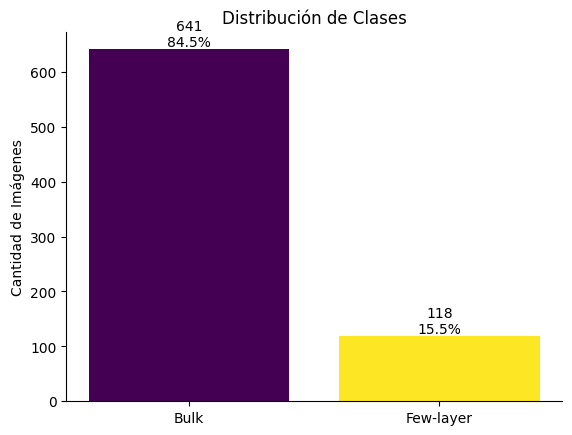

In [ ]:
clases = ['Bulk', 'Few-layer']
cantidades = [641, 118]
porcentajes = [cantidades[0] / sum(cantidades) * 100, cantidades[1] / sum(cantidades) * 100]

fig, ax = plt.subplots()
barras = ax.bar(clases, cantidades, color=plt.cm.viridis(np.linspace(0, 1, len(clases))))

for barra, cantidad, porcentaje in zip(barras, cantidades, porcentajes):
    altura = barra.get_height()
    ax.text(barra.get_x() + barra.get_width() / 2, altura, f'{cantidad}\n{porcentaje:.1f}%',
            ha='center', va='bottom')

ax.set_title('Distribución de Clases')
ax.set_ylabel('Cantidad de Imágenes')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

##6.2. Distribución de clases a nivel de pixeles

También se hizó el análisis a nivel de pixeles, contando y estableciendo relaciones de las tres clases de pixeles que puede tomar un pixel en nuestro problema (Background, Bulk, Few-Layer), se estable que existe un desbalance significativo del background con respecto a las dos clases de interes.


In [ ]:
color_counts = defaultdict(int)

iteradores = [train_masks, test_masks, valid_masks]
for iterador in iteradores:
  # Iteramos sobre cada máscara en train_masks
  for mask_rgb in iterador:
      # Obtenemos los colores únicos y sus conteos en la máscara actual
      unique_colors, counts = np.unique(mask_rgb.reshape(-1, 3), axis=0, return_counts=True)

      # Sumamos el conteo de cada color al diccionario color_counts
      for color, count in zip(unique_colors, counts):
          color_counts[tuple(color)] += count  # Usamos tuple(color) para que sea hashable

# Imprimimos el resultado
print("Cantidad total de píxeles por clase en todas las máscaras:")
for color, total_count in color_counts.items():
    print(f"Color: {color}, Cantidad total: {total_count}")

Cantidad total de píxeles por clase en todas las máscaras:
Color: (0, 0, 0), Cantidad total: 13032673
Color: (1, 1, 1), Cantidad total: 3413104
Color: (2, 2, 2), Cantidad total: 69295


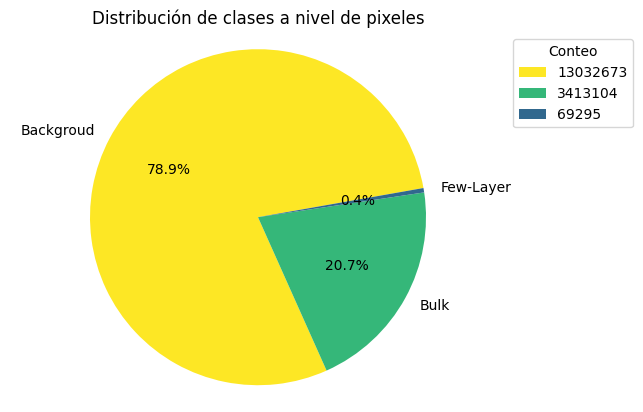

In [ ]:
labels = list(color_counts.keys())
sizes = list(color_counts.values())

fig, ax = plt.subplots()
ax.pie(sizes, labels=['Backgroud', 'Bulk', 'Few-Layer'], autopct='%1.1f%%', startangle=10, colors=plt.cm.viridis(np.linspace(1, 0, 4)))
ax.axis('equal')
ax.set_title('Distribución de clases a nivel de pixeles')
ax.legend(sizes,loc='upper left', bbox_to_anchor=(1, 1), title='Conteo')

plt.show()

##6.3 Mapa de calor

Se generan mapas de calor para identificar áreas comunes donde aparecen las clases dentro de las imágenes, lo cual es útil para detectar patrones espaciales.

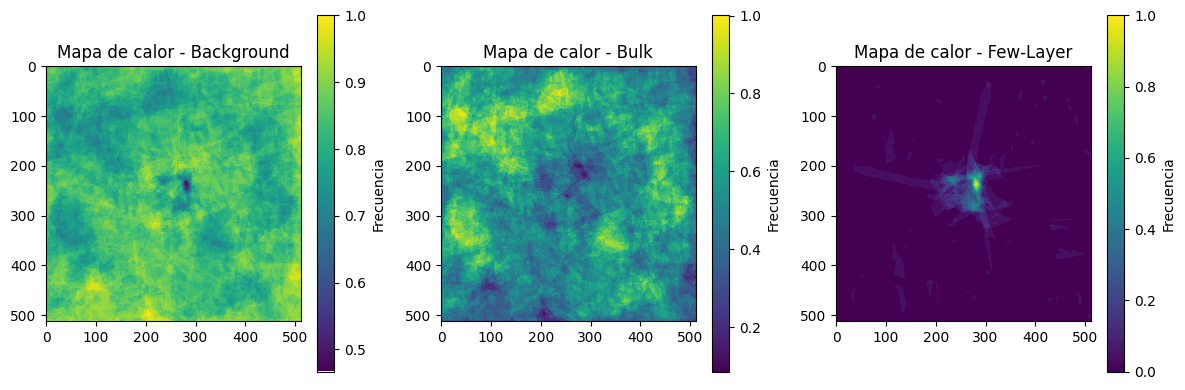

In [ ]:
colors = {
    "Background": (0, 0, 0),
    "Bulk": (1, 1, 1),
    "Few-Layer": (2, 2, 2)
}


heatmaps = {key: np.zeros_like(train_masks[0][:, :, 0], dtype=np.float32) for key in colors.keys()}

iteradores = [train_masks, test_masks, valid_masks]
for iterador in iteradores:
  for mask_rgb in iterador:
      for class_name, color in colors.items():
          class_mask = np.all(mask_rgb == color, axis=-1)
          # Sumamos la presencia de la clase en el mapa de calor correspondiente
          heatmaps[class_name] += class_mask


for key in heatmaps:
    heatmaps[key] /= heatmaps[key].max()

plt.figure(figsize=(12, 4))
for i, (class_name, heatmap) in enumerate(heatmaps.items(), 1):
    plt.subplot(1, len(heatmaps), i)
    plt.imshow(heatmap, cmap='viridis', interpolation='nearest')
    plt.title(f"Mapa de calor - {class_name}")
    plt.colorbar(label='Frecuencia')
plt.tight_layout()
plt.show()

#7. Análisis de carácteristicas

## 7.1. Histograma de intensidad en escala de grises
Se observa que la mayoria de pixeles poseen una intensidad entre 20 y 90

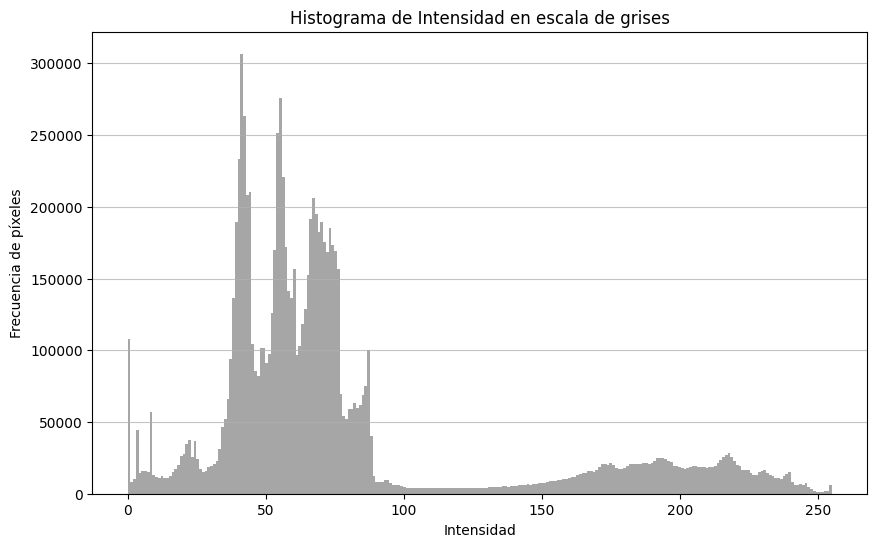

In [ ]:
img_iterador = [train_images, test_images, valid_images]
for iter in img_iterador:
  all_intensities = np.concatenate([mask.flatten() for mask in iter])

plt.figure(figsize=(10, 6))
plt.hist(all_intensities, bins=256, range=(0, 255), color='gray', alpha=0.7)
plt.title('Histograma de Intensidad en escala de grises')
plt.xlabel('Intensidad')
plt.ylabel('Frecuencia de píxeles')
plt.grid(axis='y', alpha=0.75)
plt.show()

##7.2. Histograma del canal RGB
Los tres canales tienen distribuciones muy similares, lo que nos indica que nuestras imagenes no varian mucho al ser trabajadas en escalas de blanco y negro

In [ ]:
def combined_histogram(train_images):
    hist_r = np.zeros(256)
    hist_g = np.zeros(256)
    hist_b = np.zeros(256)

    for img in train_images:
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        r, g, b = cv2.split(img_rgb)
        hist_r += np.histogram(r.flatten(), bins=256, range=[0, 256])[0]
        hist_g += np.histogram(g.flatten(), bins=256, range=[0, 256])[0]
        hist_b += np.histogram(b.flatten(), bins=256, range=[0, 256])[0]
    plt.figure(figsize=(10, 6))
    plt.title('Histograma Combinado de Intensidad RGB')
    plt.xlabel('Intensidad')
    plt.ylabel('Frecuencia')
    plt.bar(np.arange(256), hist_r, color='red', alpha=0.5, label='Rojo')
    plt.bar(np.arange(256), hist_g, color='green', alpha=0.5, label='Verde')
    plt.bar(np.arange(256), hist_b, color='blue', alpha=0.5, label='Azul')

    plt.legend()
    plt.show()

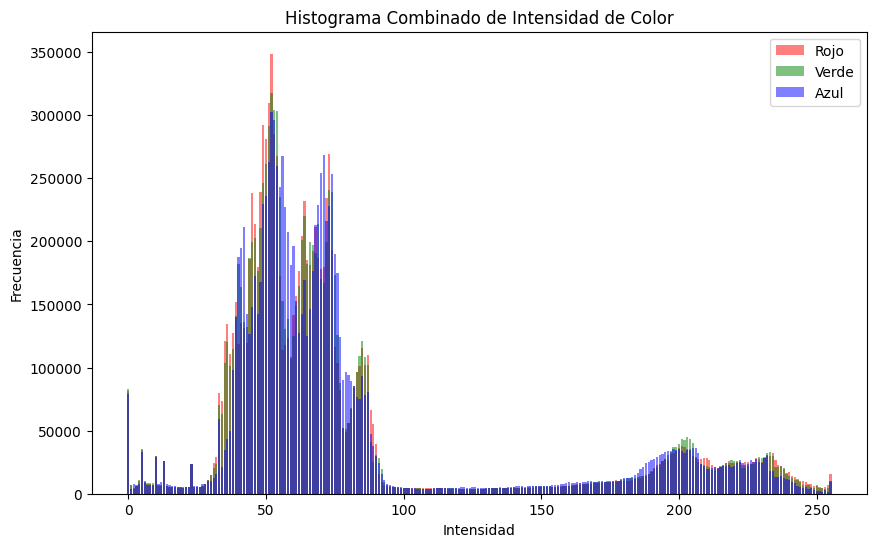

In [ ]:
combined_histogram(train_images)

## 7.3. Diagrama de cajas canales RGB segmentado por clases
Se grafican las cajas haciendo una segmentación por canal y por clase, se obtiene que la clase Bulk tiene distribución significativamente diferente a las demás clases, sin embargo tiene mucha varianza en sus tres canales.
La clase Background y Few-Layer tienen distribuciones muy similares, siendo la clase few-layer la que posee un poco menos de varianza, y una mediana mayor, lo que indica que sus pixeles tienen una mayor intensidad en todos sus canales con respecto a la clase background

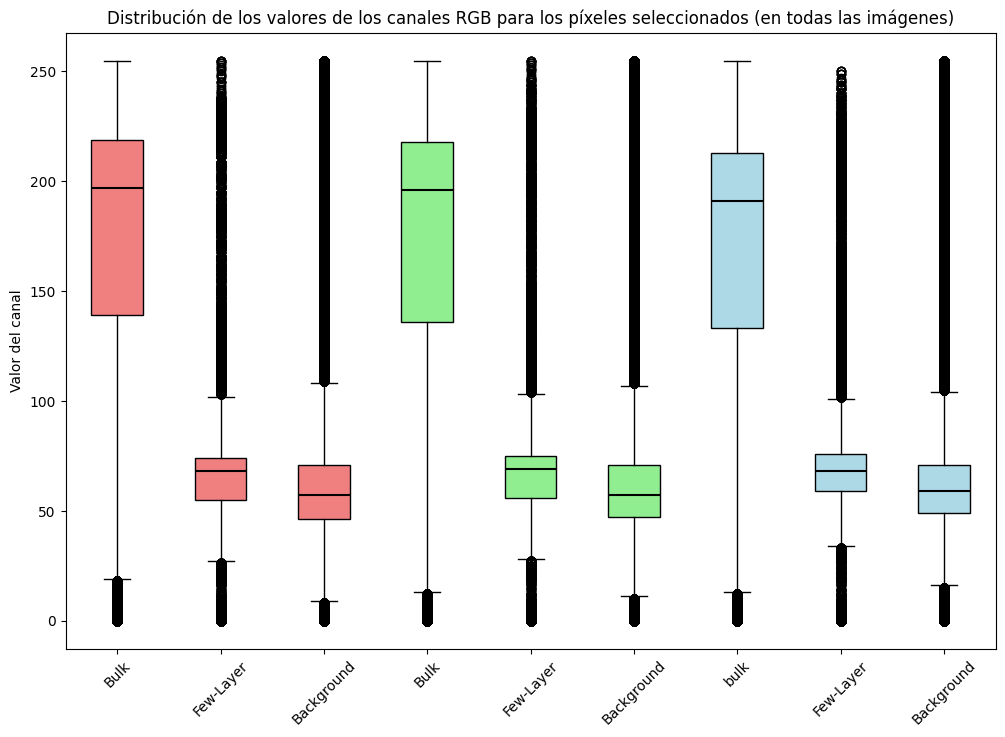

In [ ]:
canales_rojo_222 = []
canales_verde_222 = []
canales_azul_222 = []

canales_rojo_111 = []
canales_verde_111 = []
canales_azul_111 = []

canales_rojo_000 = []
canales_verde_000 = []
canales_azul_000 = []

# Función para extraer los píxeles de la imagen según un valor específico de la máscara
def obtener_pixeles_por_mascara(mascara, imagen, valor_mascara):
    mascara_booleana = np.all(mascara == valor_mascara, axis=-1)
    return imagen[mascara_booleana]

# Función para procesar un conjunto de imágenes y máscaras
def procesar_conjunto(imagenes, mascaras):
    for imagen, mascara in zip(imagenes, mascaras):
        if imagen.shape != mascara.shape:
            raise ValueError("La imagen y la máscara deben tener las mismas dimensiones.")

        # Extraer los píxeles correspondientes a las máscaras (2, 2, 2), (1, 1, 1) y (0, 0, 0)
        pixeles_imagen_222 = obtener_pixeles_por_mascara(mascara, imagen, [2, 2, 2])
        pixeles_imagen_111 = obtener_pixeles_por_mascara(mascara, imagen, [1, 1, 1])
        pixeles_imagen_000 = obtener_pixeles_por_mascara(mascara, imagen, [0, 0, 0])

        # Separar los canales R, G y B para cada conjunto de píxeles
        canales_rojo_222.extend(pixeles_imagen_222[:, 2])  # Canal rojo (BGR)
        canales_verde_222.extend(pixeles_imagen_222[:, 1])  # Canal verde
        canales_azul_222.extend(pixeles_imagen_222[:, 0])  # Canal azul

        canales_rojo_111.extend(pixeles_imagen_111[:, 2])
        canales_verde_111.extend(pixeles_imagen_111[:, 1])
        canales_azul_111.extend(pixeles_imagen_111[:, 0])

        canales_rojo_000.extend(pixeles_imagen_000[:, 2])
        canales_verde_000.extend(pixeles_imagen_000[:, 1])
        canales_azul_000.extend(pixeles_imagen_000[:, 0])

# Procesar cada conjunto por separado
procesar_conjunto(train_images, train_masks)
procesar_conjunto(valid_images, valid_masks)
procesar_conjunto(test_images, test_masks)

# Crear el diagrama de cajas (box plot)
plt.figure(figsize=(12, 8))

# Colores para cada grupo de canal (Rojo, Verde, Azul)
colores = ['lightcoral', 'lightgreen', 'lightblue']  # Colores para Rojo, Verde, Azul

# Graficar todos los canales para las tres máscaras (2, 2, 2), (1, 1, 1), (0, 0, 0)
box = plt.boxplot([
                   canales_rojo_111, canales_rojo_222, canales_rojo_000,  # Rojo
                   canales_verde_111, canales_verde_222, canales_verde_000,  # Verde
                   canales_azul_111, canales_azul_222, canales_azul_000],  # Azul
                  patch_artist=True, labels=[
                      'Bulk', 'Few-Layer', 'Background',  # Rojo
                      'Bulk', 'Few-Layer', 'Background',  # Verde
                      'bulk', 'Few-Layer', 'Background'   # Azul
                  ])

# Asignar colores a las cajas (rojos, verdes, azules)
for i in range(len(box['boxes'])):
    if i < 3:
        box['boxes'][i].set_facecolor(colores[0])
    elif i < 6:
        box['boxes'][i].set_facecolor(colores[1])
    else:
        box['boxes'][i].set_facecolor(colores[2])

# Establecer color para las medianas
for median in box['medians']:
    median.set_color('black')  # Color de la mediana
    median.set_linewidth(1.5)

# Título y etiquetas
plt.title('Distribución de los valores de los canales RGB para los píxeles seleccionados (en todas las imágenes)')
plt.ylabel('Valor del canal')
plt.xticks(rotation=45)  # Rotar las etiquetas para mejor legibilidad

# Mostrar el gráfico
plt.show()

##7.4. Imagenes filtradas por canal

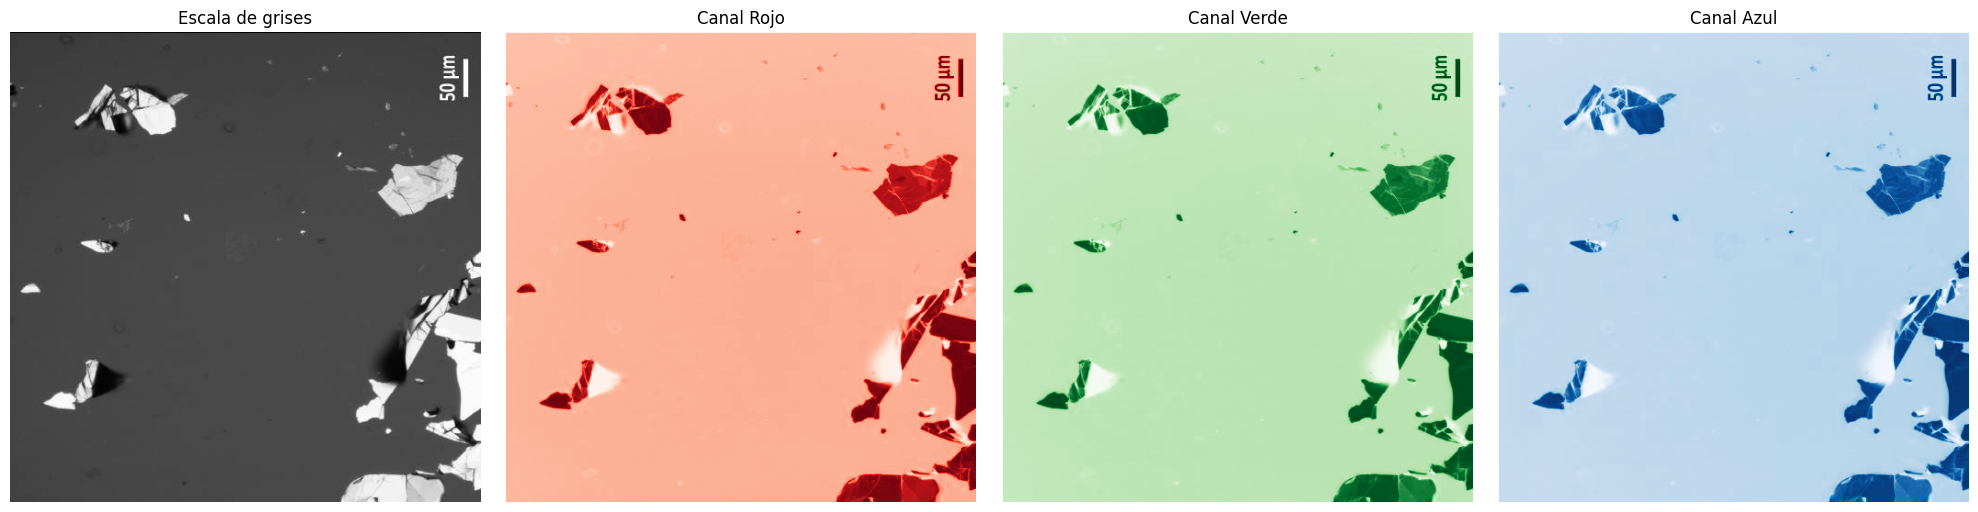

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

gray_image = cv2.cvtColor(train_images[7], cv2.COLOR_BGR2GRAY)
axs[0].imshow(gray_image, cmap='gray')
axs[0].set_title('Escala de grises')
axs[0].axis('off')

red_channel = train_images[7][:, :, 2]
axs[1].imshow(red_channel, cmap='Reds')
axs[1].set_title('Canal Rojo')
axs[1].axis('off')


green_channel = train_images[7][:, :, 1]
axs[2].imshow(green_channel, cmap='Greens')
axs[2].set_title('Canal Verde')
axs[2].axis('off')

blue_channel = train_images[7][:, :, 0]
axs[3].imshow(blue_channel, cmap='Blues')
axs[3].set_title('Canal Azul')
axs[3].axis('off')

plt.tight_layout()
plt.show()

##7.5. Modelo HSV
Este modelo determina el matiz, la saturación y el valor del pixel.
La imagen muestra que tiene colores poco saturados, lo cual indica una paleta apagada o desaturada. Además, exhibe una gama de niveles de brillo desde áreas oscuras hasta zonas bien iluminadas, lo que sugiere contrastes moderados en la iluminación. Esta combinación es típica de una imagen con pocos colores vibrantes pero con variación en luz y sombras.

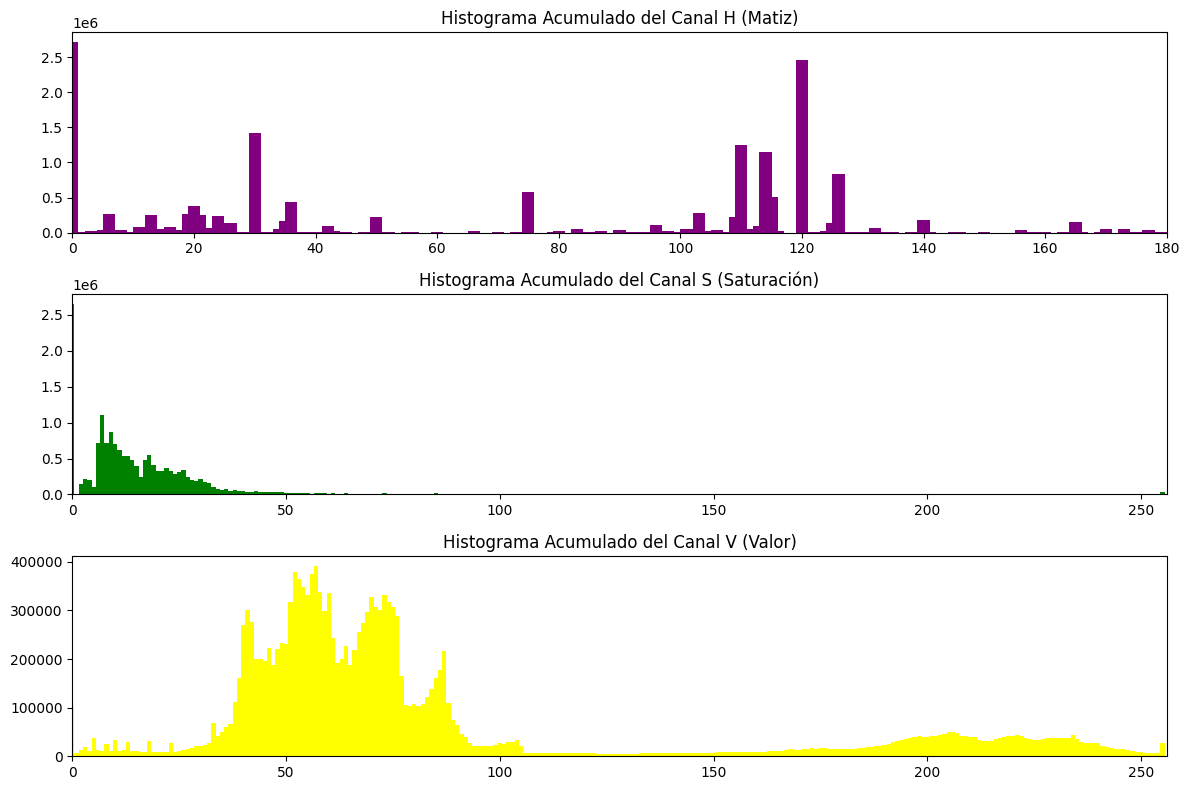

In [ ]:
hist_h_total = np.zeros(180)
hist_s_total = np.zeros(256)
hist_v_total = np.zeros(256)

iteradores = [train_images, valid_images, test_images]

for iter in iteradores:
  for image in iter:
      hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
      h, s, v = cv2.split(hsv_image)

      # Calcular y acumular histogramas
      hist_h, _ = np.histogram(h.flatten(), bins=180, range=[0, 180])
      hist_s, _ = np.histogram(s.flatten(), bins=256, range=[0, 256])
      hist_v, _ = np.histogram(v.flatten(), bins=256, range=[0, 256])

      hist_h_total += hist_h
      hist_s_total += hist_s
      hist_v_total += hist_v

# Graficar los histogramas acumulados
plt.figure(figsize=(12, 8))

# Histograma del canal H
plt.subplot(3, 1, 1)
plt.title('Histograma Acumulado del Canal H (Matiz)')
plt.bar(range(180), hist_h_total, color='purple', width=2)
plt.xlim([0, 180])

# Histograma del canal S
plt.subplot(3, 1, 2)
plt.title('Histograma Acumulado del Canal S (Saturación)')
plt.bar(range(256), hist_s_total, color='green', width=1)
plt.xlim([0, 256])

# Histograma del canal V
plt.subplot(3, 1, 3)
plt.title('Histograma Acumulado del Canal V (Valor)')
plt.bar(range(256), hist_v_total, color='yellow', width=1)
plt.xlim([0, 256])

plt.tight_layout()
plt.show()

## 7.6. Diagrama de cajas HSV por clases

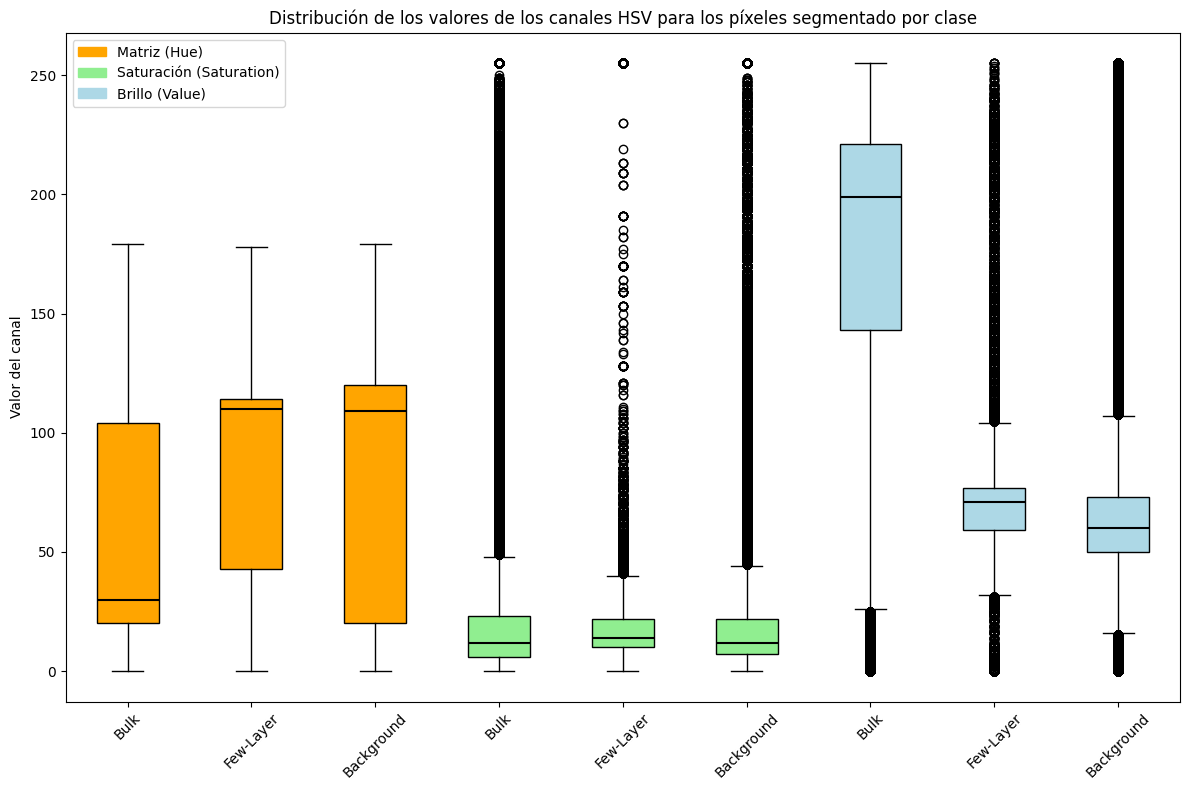

In [ ]:
import matplotlib.patches as mpatches

# Listas para almacenar los valores de los canales H, S, V para cada valor de máscara
canales_h_222 = []
canales_s_222 = []
canales_v_222 = []

canales_h_111 = []
canales_s_111 = []
canales_v_111 = []

canales_h_000 = []
canales_s_000 = []
canales_v_000 = []

# Función para extraer los píxeles de la imagen en HSV según un valor específico de la máscara
def obtener_pixeles_por_mascara(mascara, imagen_hsv, valor_mascara):
    mascara_booleana = np.all(mascara == valor_mascara, axis=-1)
    return imagen_hsv[mascara_booleana]

# Función para procesar un conjunto de imágenes y máscaras en HSV
def procesar_conjunto_hsv(imagenes, mascaras):
    for imagen, mascara in zip(imagenes, mascaras):
        if imagen.shape != mascara.shape:
            raise ValueError("La imagen y la máscara deben tener las mismas dimensiones.")

        imagen_hsv = cv2.cvtColor(imagen, cv2.COLOR_BGR2HSV)

        # Extraer los píxeles correspondientes a las máscaras (2, 2, 2), (1, 1, 1) y (0, 0, 0)
        pixeles_imagen_222 = obtener_pixeles_por_mascara(mascara, imagen_hsv, [2, 2, 2])
        pixeles_imagen_111 = obtener_pixeles_por_mascara(mascara, imagen_hsv, [1, 1, 1])
        pixeles_imagen_000 = obtener_pixeles_por_mascara(mascara, imagen_hsv, [0, 0, 0])

        # Separar los canales H, S y V para cada conjunto de píxeles
        canales_h_222.extend(pixeles_imagen_222[:, 0])  # Canal H (Hue)
        canales_s_222.extend(pixeles_imagen_222[:, 1])  # Canal S (Saturation)
        canales_v_222.extend(pixeles_imagen_222[:, 2])  # Canal V (Value)

        canales_h_111.extend(pixeles_imagen_111[:, 0])
        canales_s_111.extend(pixeles_imagen_111[:, 1])
        canales_v_111.extend(pixeles_imagen_111[:, 2])

        canales_h_000.extend(pixeles_imagen_000[:, 0])
        canales_s_000.extend(pixeles_imagen_000[:, 1])
        canales_v_000.extend(pixeles_imagen_000[:, 2])

procesar_conjunto_hsv(train_images, train_masks)
procesar_conjunto_hsv(valid_images, valid_masks)
procesar_conjunto_hsv(test_images, test_masks)

plt.figure(figsize=(12, 8))

colores_hsv = ['orange', 'lightgreen', 'lightblue']

box = plt.boxplot([
                   canales_h_111, canales_h_222, canales_h_000,
                   canales_s_111, canales_s_222, canales_s_000,
                   canales_v_111, canales_v_222, canales_v_000],
                  patch_artist=True, labels=[
                      'Bulk', 'Few-Layer', 'Background',
                      'Bulk', 'Few-Layer', 'Background',
                      'Bulk', 'Few-Layer', 'Background'
                  ])

for i in range(len(box['boxes'])):
    if i < 3:
        box['boxes'][i].set_facecolor(colores_hsv[0])
    elif i < 6:
        box['boxes'][i].set_facecolor(colores_hsv[1])
    else:
        box['boxes'][i].set_facecolor(colores_hsv[2])

# Establecer color para las medianas
for median in box['medians']:
    median.set_color('black')  # Color de la mediana
    median.set_linewidth(1.5)


plt.title('Distribución de los valores de los canales HSV para los píxeles segmentado por clase')
plt.ylabel('Valor del canal')
plt.xticks(rotation=45)
leyenda_h = mpatches.Patch(color='orange', label='Matriz (Hue)')
leyenda_s = mpatches.Patch(color='lightgreen', label='Saturación (Saturation)')
leyenda_v = mpatches.Patch(color='lightblue', label='Brillo (Value)')
plt.legend(handles=[leyenda_h, leyenda_s, leyenda_v])
plt.tight_layout()

plt.show()

In [ ]:
LAB